In [1]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


GPU Available: True
Device Name: Tesla T4


# VGG Model

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


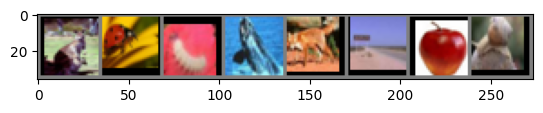

Epoch 1/50, Loss: 3.0048, Val Loss: 2.1700
Epoch 2/50, Loss: 2.0939, Val Loss: 1.8478
Epoch 3/50, Loss: 1.8103, Val Loss: 1.7119
Epoch 4/50, Loss: 1.6414, Val Loss: 1.6299
Epoch 5/50, Loss: 1.5070, Val Loss: 1.5903
Epoch 6/50, Loss: 1.4002, Val Loss: 1.4739
Epoch 7/50, Loss: 1.3006, Val Loss: 1.4750
Epoch 8/50, Loss: 1.2362, Val Loss: 1.4181
Epoch 9/50, Loss: 1.1594, Val Loss: 1.4064
Epoch 10/50, Loss: 1.1008, Val Loss: 1.3873
Epoch 11/50, Loss: 1.0413, Val Loss: 1.4190
Epoch 12/50, Loss: 0.9799, Val Loss: 1.3578
Epoch 13/50, Loss: 0.9283, Val Loss: 1.3633
Epoch 14/50, Loss: 0.8811, Val Loss: 1.3654
Epoch 15/50, Loss: 0.8337, Val Loss: 1.3478
Epoch 16/50, Loss: 0.7969, Val Loss: 1.3505
Epoch 17/50, Loss: 0.7566, Val Loss: 1.3231
Epoch 18/50, Loss: 0.7276, Val Loss: 1.3740
Epoch 19/50, Loss: 0.6835, Val Loss: 1.3738
Epoch 20/50, Loss: 0.6474, Val Loss: 1.3532
Epoch 21/50, Loss: 0.4917, Val Loss: 1.3576
Epoch 22/50, Loss: 0.4658, Val Loss: 1.3698
Epoch 23/50, Loss: 0.4484, Val Loss: 1.39

<ipython-input-3-c84f36e87fb4>:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vgg.load_state_dict(torch.load(best_model_path))


Final Test Accuracy: 65.08%


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =================== 1. Load Data and Data Augmentation ===================
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
full_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# =================== 2. Display Sample Images ===================
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))

# =================== 3. Define VGG-16 Model ===================
model_vgg = models.vgg16(pretrained=True)
model_vgg.classifier[6] = nn.Linear(4096, 100)  # Adjust output for 100 classes in CIFAR-100
model_vgg = model_vgg.to(device)

# =================== 4. Define Loss Function and Optimizer ===================
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # Reduce LR every 20 epochs

# =================== 5. Train the Model with Validation ===================
best_val_loss = float('inf')
best_model_path = "best_vgg16_cifar100.pth"
num_epochs = 50
for epoch in range(num_epochs):
    model_vgg.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_vgg(images)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_vgg.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    # Evaluate on validation set
    val_loss = 0.0
    model_vgg.eval()
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_vgg(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(valloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}, Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_vgg.state_dict(), best_model_path)

print("Training Finished!")

# =================== 6. Load Best Model and Evaluate on Test Set ===================
model_vgg.load_state_dict(torch.load(best_model_path))
correct = 0
total = 0
model_vgg.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Final Test Accuracy: {accuracy:.2f}%")

# ResNet-50 Model

In [4]:
# =================== 1. Load Data and Data Augmentation ===================
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
full_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# =================== 2. Define ResNet-50 Model with Dropout ===================
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout to reduce overfitting
    nn.Linear(512, 100)
)
model_resnet50 = model_resnet50.to(device)

# =================== 3. Define Loss Function and Optimizer ===================
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet50.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

# =================== 4. Train the Model (NO EARLY STOPPING) ===================
best_model_path = "best_resnet50_cifar100.pth"
num_epochs = 50

for epoch in range(num_epochs):
    model_resnet50.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_resnet50(images)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_resnet50.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    scheduler.step()
    train_accuracy = 100 * correct_train / total_train

    # Evaluate on validation set
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    model_resnet50.eval()
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet50(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    val_accuracy = 100 * correct_val / total_val
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Save best model
    torch.save(model_resnet50.state_dict(), best_model_path)

print("Training Finished!")

# =================== 5. Load Best Model and Evaluate on Test Set ===================
model_resnet50.load_state_dict(torch.load(best_model_path))
correct = 0
total = 0
model_resnet50.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet50(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# =================== 6. Save the Final Model ===================
torch.save(model_resnet50.state_dict(), "final_resnet50_cifar100.pth")


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Loss: 4.3501, Train Acc: 6.45%, Val Loss: 3.7701, Val Acc: 17.24%
Epoch 2/50, Loss: 3.2872, Train Acc: 21.64%, Val Loss: 2.7021, Val Acc: 32.16%
Epoch 3/50, Loss: 2.5925, Train Acc: 33.01%, Val Loss: 2.2950, Val Acc: 40.17%
Epoch 4/50, Loss: 2.2351, Train Acc: 41.05%, Val Loss: 2.0399, Val Acc: 45.79%
Epoch 5/50, Loss: 2.0128, Train Acc: 45.95%, Val Loss: 1.8886, Val Acc: 49.27%
Epoch 6/50, Loss: 1.8311, Train Acc: 50.35%, Val Loss: 1.8049, Val Acc: 51.03%
Epoch 7/50, Loss: 1.7415, Train Acc: 52.48%, Val Loss: 1.7699, Val Acc: 52.19%
Epoch 8/50, Loss: 1.6656, Train Acc: 54.39%, Val Loss: 1.7240, Val Acc: 53.06%
Epoch 9/50, Loss: 1.6026, Train Acc: 55.80%, Val Loss: 1.6922, Val Acc: 54.12%
Epoch 10/50, Loss: 1.5429, Train Acc: 57.40%, Val Loss: 1.6720, Val Acc: 54.51%
Epoch 11/50, Loss: 1.4866, Train Acc: 58.84%, Val Loss: 1.6337, Val Acc: 55.59%
Epoch 12/50, Loss: 1.4370, Train Ac

<ipython-input-4-447fd4432e26>:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_resnet50.load_state_dict(torch.load(best_model_path))


Final Test Accuracy: 58.90%
